## Data

In [1]:
import numpy as np
import pandas as pd
from pandasql import sqldf
import plotly.graph_objects as go
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
%%capture
fig, ax = plt.subplots()

In [3]:
file_name = 'p-2021-11-13 raw log.csv'
df = pd.read_csv(f'./data/processed/{file_name}')

In [4]:
df['hand_num'] = pd.to_numeric(df['hand_num'])
df['at'] = pd.to_datetime(df['at'])

## Analysis

### Games statistics

**1. What are the pot size distributions?**

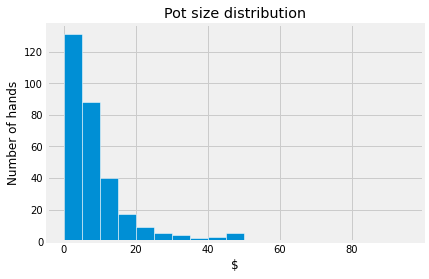

In [5]:
ax.clear()
df.groupby('hand_num')['pot_size'].max().sort_values(ascending=False).to_frame().hist(ax=ax, ec='white', bins=range(0, 100, 5))
ax.set_title('Pot size distribution')
ax.set_ylabel('Number of hands')
ax.set_xlabel('$')
fig

Unsurprisingly the distribution is heavily skewed. The majority of pots are pretty small, in the $0-$10 range. There are only a few hands where the pot exceeded $50.

**2. At which phases are the hands won?**

Judging from the result, we can conclude that the game was pretty casual as it often went to River. My hypothesis is that good players have better evaluation of their hands strength, hence they can make decisions earlier (eg. folding earlier). Meanwhile, at a lower stake game, player don't lose much in terms of dollar value hence it's ok to commit longer.

We can verify this by comparing hand end phase vs. a higher stake game.

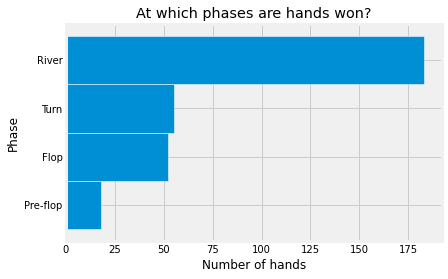

In [6]:
ax.clear()
df.loc[df['action']=='Won'].groupby('hand_num')['phase'].max().value_counts(dropna=False, ascending=True).plot(ax=ax, kind='barh', width=1, ec='white')
ax.set_title('At which phases are hands won?')
ax.set_ylabel('Phase')
ax.set_xlabel('Number of hands')
fig

**3. How many pots were split?**

We can determine by counting the number of winners per hand

In [7]:
df.loc[df['action']=='Won']['hand_num'].value_counts().value_counts()

1    302
2      6
Name: hand_num, dtype: int64

### Individual player statistics

**1. Overview:  Number of hands played, Winnings, Win per hand**

By itself number of hands played only shows how many hands the players sit in. But will be useful to calculate the various playstyle metrics below.

We can make a reasonable assumption that, given enough hands, the better players win more. Next we will analyse different patterns of behaviors. Hopefully we can learn from the winners here.

In [8]:
# pl = player dataframe to store all metrics
pl = df.loc[(df['phase']=='Pre-flop') & (df['rank-P1']==1)]['player_name'].value_counts(dropna=False).to_frame(name='num_hands_played')
_winnings = df.loc[df['action']=='Won'].groupby('player_name')['_amount'].sum().sort_values()
_winnings.name = 'gross_win'
pl = pl.merge(_winnings, left_index=True, right_index=True)
pl['win_per_hand'] = (pl['gross_win'] / pl['num_hands_played']).round(2)

<AxesSubplot:title={'center':'Win per hand'}>

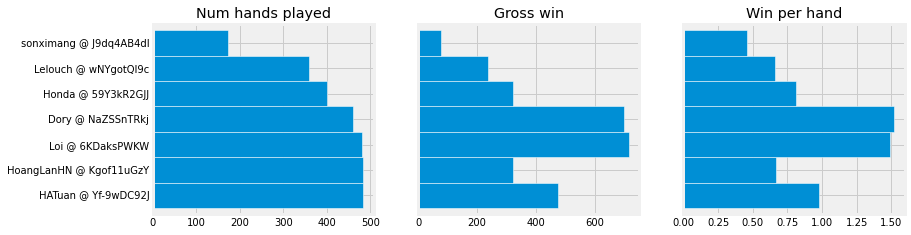

In [9]:
fig2, axes = plt.subplots(1, 3, figsize=(12, 3.5), sharey=True)
pl['num_hands_played'].plot(ax=axes[0], title='Num hands played', kind='barh', width=1, ec='white')
pl['gross_win'].plot(ax=axes[1], title='Gross win', kind='barh', ec='white', width=1)
pl['win_per_hand'].plot(ax=axes[2], title='Win per hand', kind='barh', ec='white', width=1)

# ax.set_ylabel('')

From this chart we can see that Loi @ 6k.. is a good player. We will try to find out how he plays!

**2. VPIP: Voluntarily Put In Pot & PFR: Pre-flop Raises**

VPIP tracks the percentage of hands in which a particular player voluntarily puts money into the pot preflop. VPIP increases when a player could fold but instead commits money to the pot preflop. This includes limping (merely calling the big blind), calling, and raising.

PFR tracks the percentage of hands in which a particular player makes a preflop raise when having the opportunity to fold or call instead. This includes reraises. By definition, PFR is a subset of VPIP. So we will plot the ratio PFR/VPIP to measure player's tendency.


In [10]:
# VPIP
_vpip = df.loc[(df['phase']=='Pre-flop') &
    (df['rank-P2']==1) &
    (df['action'].isin(['Bets/Raises', 'Calls']))
    ]['player_name'].value_counts(dropna=False)
_vpip.name = 'VPIP'
pl = pl.merge(_vpip, how='left', left_index=True, right_index=True)
pl['% VPIP'] = (pl['VPIP'] / pl['num_hands_played']).round(2)

# PFR / VPIP
_pfr = df.loc[(df['phase']=='Pre-flop') &
    (df['action']=='Bets/Raises')][['player_name', 'hand_num']].drop_duplicates()['player_name'].value_counts()
_pfr.name = 'PFR'
pl = pl.merge(_pfr, how='left', left_index=True, right_index=True)
pl['FPR / VPIP'] = (pl['PFR'] / pl['VPIP']).round(2)

<AxesSubplot:title={'center':'PFR / VPIP'}>

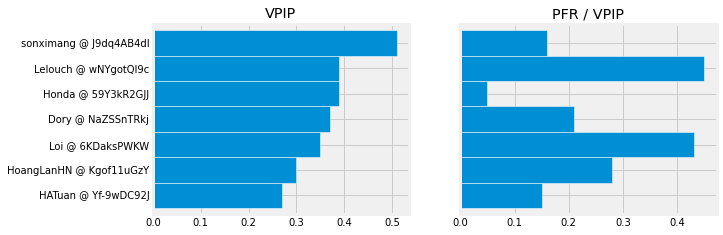

In [11]:
fig3, axes = plt.subplots(1, 2, figsize=(9, 3.5), sharey=True)
pl.sort_values(by='% VPIP')['% VPIP'].plot(ax=axes[0], kind='barh', title='VPIP', width=1, ec='white')
pl['FPR / VPIP'].plot(ax=axes[1], kind='barh', title='PFR / VPIP', width=1, ec='white')

It's clearer now that the winning players play fewer hands (lower % VPIP). But when they play, they are more aggressive with raisings!

**3. 3-BET and C-BET** (WIP)

In [12]:
_3bet = df.loc[(df['phase']=='Pre-flop') &
    (df['action']=='Bets/Raises') &
    (df['rank-A2']>1)]['player_name'].value_counts(dropna=False).fillna(0)
_3bet.name = '3-BET'
pl = pl.merge(_3bet, how='left', left_index=True, right_index=True)
pl['% 3-BET'] = (pl['3-BET'] / pl['num_hands_played']).round(3)

<AxesSubplot:title={'center':'3-BET'}>

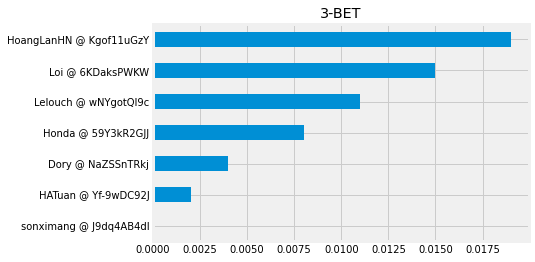

In [13]:
pl.sort_values(by='% 3-BET', na_position='first')['% 3-BET'].plot(kind='barh', title='3-BET')

**4. Wins and positions**

Good players play positions as well!
* EP: Early positions
* MP: Middle positions
* LP: Late positions

In [14]:
_pos = df.loc[df['action']=='Won'].pivot_table(
    index='player_name',
    columns='position_tag',
    values='hand_num',
    aggfunc=len,
    fill_value=0,
)
_pos['Total'] = _pos.sum(axis=1)

_pos.columns.name = None
for col in _pos.columns:
    if col != 'Total':
        _pos[f'Win at {col}'] = _pos[col] / _pos['Total']

_pos = _pos.round(3)
_pos_pct = _pos[[col for col in _pos.columns if col.startswith('Win at')]]

_pos_pct

,Win at Dealer,Win at EP,Win at LP,Win at MP
player_name,,,,
Dory @ NaZSSnTRkj,0.122,0.163,0.408,0.306
HATuan @ Yf-9wDC92J,0.196,0.137,0.333,0.333
HoangLanHN @ Kgof11uGzY,0.059,0.333,0.314,0.294
Honda @ 59Y3kR2GJJ,0.196,0.152,0.261,0.391
Lelouch @ wNYgotQI9c,0.100,0.133,0.367,0.400
Loi @ 6KDaksPWKW,0.260,0.192,0.233,0.315
sonximang @ J9dq4AB4dI,0.214,0.429,0.357,0.000


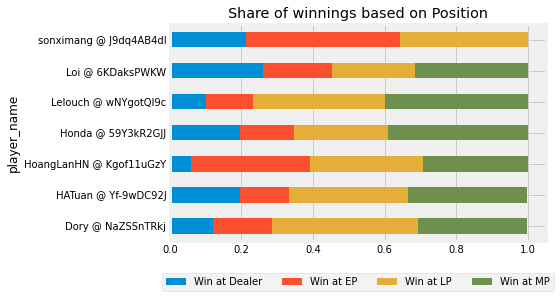

In [15]:
fig4, ax = plt.subplots()
_pos_pct.plot(ax=ax, kind='barh', stacked=True, title='Share of winnings based on Position')
ax.legend(loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.25))

Loi @ 6KD.. won a lot more when he's the dealer compared to the rest of the players.